In [45]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from scipy import signal, misc
from datetime import datetime

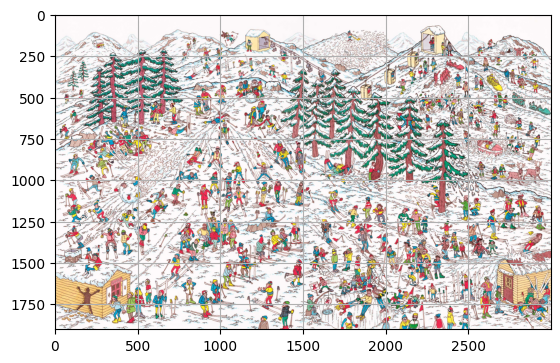

In [2]:
waldo_img = mpimg.imread('hi_res_waldo.jpg')
plt.imshow(waldo_img)
plt.axis("on")
plt.grid(True)
plt.show()

I turned on the axis and the grid to hopefully cut down on how long it would take me to determine the cropping size after finding Waldo manually. Next, I attempted to crop the image. To crop the image, I am essentially using the principles of python indexing and splicing to communicate with the computer and to get a cropped version of the image return. For the next section, I used guess and check to figure out the cropping indices.

In [3]:
print(waldo_img.shape)

(1902, 3000, 3)


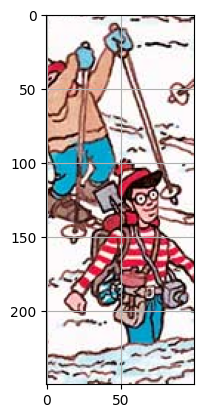

In [8]:
#image[y1:y2, x1:x2]
cropped_waldo = waldo_img[1250:1500, 2500:2600]
plt.imshow(cropped_waldo)
plt.axis("on")
plt.grid(True)
plt.show()

Okay! I am going to try to do some edge enhancing? I am gonna see what happens when I pass the cropped image with a high-pass-filter.

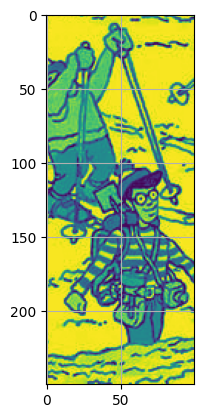

In [9]:
#mkaing the image greyscale
def rgb2gray(rgb):
    gray = np.dot(rgb, [.2989, .587, .1140])
    return gray

gray_waldo_c = rgb2gray(cropped_waldo)
plt.imshow(gray_waldo_c)
plt.axis("on")
plt.grid(True)
plt.show()

^ something went amock here, i will return

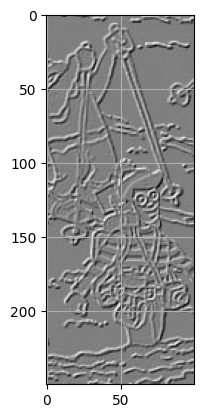

In [24]:
#2D hpf
HPF2D = np.zeros((2,2))
HPF2D[0::] = [-1, 0]
HPF2D[1::] = [0, 1]

#now i will convolve the 2D HPF matrix with my image
HPRI = signal.convolve2d(gray_waldo_c, np.matrix(HPF2D), mode='same')

#fingers crossed, please look okay
plt.imshow(HPRI, cmap='gray', vmin=-np.abs(HPRI).max(), vmax=np.abs(HPRI).max())
plt.axis("on")
plt.grid(True)
plt.show()

I tried subtracting the matrices but I did not get what I wanted LOL i think I subracted the edges but I meant to subtract everything that was NOT HPRI. I will think on this lol

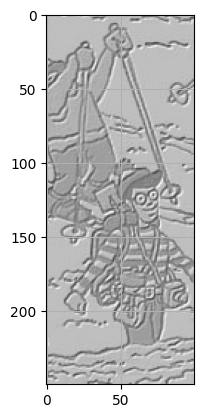

In [26]:
resulting_image = gray_waldo_c - HPRI

plt.imshow(resulting_image, cmap='gray', vmin=-np.abs(resulting_image).max(), vmax=np.abs(resulting_image).max())
plt.axis("on")
plt.grid(True)
plt.show()

I just wanted to see what would happen if I convolved the cropped with the big image:

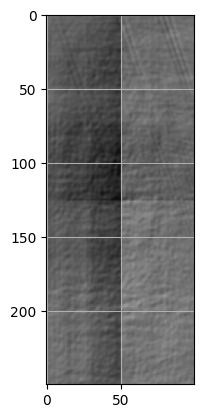

In [27]:
cropped_big_imageR = signal.convolve2d(gray_waldo_c, HPRI, mode='same')

#fingers crossed, please look okay
plt.imshow(cropped_big_imageR, cmap='gray', vmin=-np.abs(cropped_big_imageR).max(), vmax=np.abs(cropped_big_imageR).max())
plt.axis("on")
plt.grid(True)
plt.show()

epic fail

I got a little stumped on how to use these edge, you guys might have some ideas but before I update yall, I wanted to see if I really could remove the background so lets see what happensssss

I found this code on stack overflow that should maybe help me make a mask using the edge???
found here: https://stackoverflow.com/questions/29313667/how-do-i-remove-the-background-from-this-kind-of-image

This was hard so I tried a different way but I will keep this link but I still tried to use elements (using cv2 and converting my edges to 8-bit)

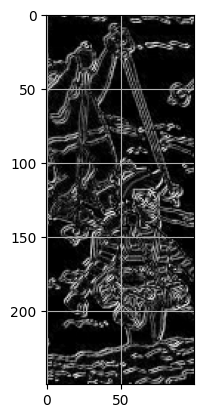

In [28]:
#i noremalized and converted the high pass filter to 8-bit
abs_HPRI = np.abs(HPRI) #gets rid of negatives
norm_HPRI = abs_HPRI/abs_HPRI.max() #divide by max of absolute value to normalize 
HPRI_8bit = np.uint8(255 * norm_HPRI) #so it still ranges from 0-255, i was getting a black square before

#lets see what i did LOL
plt.imshow(HPRI_8bit, cmap='gray')
plt.axis("on")
plt.grid(True)
plt.show()

<class 'numpy.ndarray'>


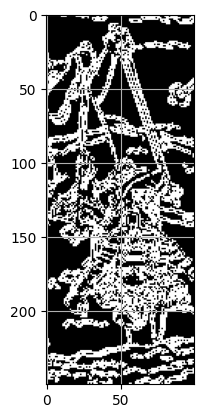

In [44]:
# step ?idek I have to make a maske based on the edges
    # this first line converts a greyscale image to a binary image based on a threshold i choose
    # it takes in my 8bitr image, pixels above 30 become white and below 30 become black
    # 255 is the max value so there should be white value pixels above this threshold (this part confuses me)
    #the underscore is a dummy variable (returns the threshold value used)
    # and the edge mask produced is just 0s and 1s for my black and white mask
    #essentially a type of logic arrays liek we do in lab:
        #if pixel_value > 30:
            #pixel_value = 255 (white)
        #else:
            #pixel_value = 0 (black)
_, edge_mask = cv2.threshold(HPRI_8bit, 30, 255, cv2.THRESH_BINARY)
print(type(edge_mask))
plt.imshow(edge_mask, cmap='gray')
plt.axis("on")
plt.grid(True)
plt.show()

In [34]:

#since i have just the edges, I have to fill the inside of the edges with stuffs
contours, _ = cv2.findContours(edge_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #finds the curves in the edges detected above
foreground_mask = np.zeros_like(edge_mask) #creates a array?? of the foreground that we want to fill in based on mask we created
cv2.drawContours(foreground_mask, contours, -1, 255, thickness=cv2.FILLED) # this line specifically fills in the contours

#this step is supposed to make the background transparent
foreground = cv2.bitwise_and(cropped_waldo, cropped_waldo, mask = foreground_mask)
foreground_rgba = cv2.cvtColor(foreground, cv2.COLOR_BGR2BGRA)
foreground_rgba[:, :, 3] = foreground_mask
cv2.imwrite('foreground.png', foreground_rgba)

True

I wanted to see what would happen if I used cv2 for edge detection

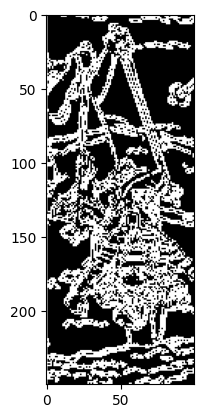

In [31]:
_, edge_mask2 = cv2.threshold(HPRI_8bit, 30, 255, cv2.THRESH_BINARY)
plt.imshow(edge_mask2, cmap='gray')

In [32]:
#since i have just the edges, I have to fill the inside of the edges with stuffs
contours2, _ = cv2.findContours(edge_mask2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #finds the curves in the edges detected above
foreground_mask2 = np.zeros_like(edge_mask2) #creates a array?? of the foreground that we want to fill in based on mask we created
cv2.drawContours(foreground_mask2, contours2, -1, 255, thickness=cv2.FILLED) # this line specifically fills in the contours

#this step is supposed to make the background transparent
foreground2 = cv2.bitwise_and(cropped_waldo, cropped_waldo, mask = foreground_mask2)
foreground_rgba2 = cv2.cvtColor(foreground2, cv2.COLOR_BGR2BGRA)
foreground_rgba2[:, :, 3] = foreground_mask2
cv2.imwrite('foreground_cv2.png', foreground_rgba2)

True

below are blocks where i try to change the initial cropping block

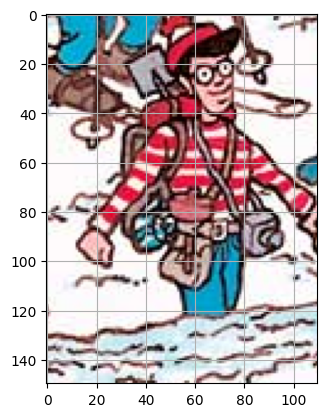

In [47]:
cropped_waldo2 = waldo_img[1350:1500, 2500:2610]
plt.imshow(cropped_waldo)
plt.axis("on")
plt.grid(True)
plt.show()

made a function out of the high pass convolving + 8bit conversion  
the workflow is as follows:

1. hand crop image
2. feed image to rgb2gray function
3. feed (2) output to hp_edge_detection function
4. plot first (3) output and feed second (3) output to png_generator function  

These functions can be used to streamline mask creation and waldo isolation for the establishment of a waldo bank, if you will.

In [53]:
def rgb2gray(rgb):
    """From Color to Grayscale

    Args:
        rgb (np.array): takes rgb image array

    Returns:
        np.array: array of greyscale image values
    """
    gray = np.dot(rgb, [.2989, .587, .1140])
    return gray

def hp_edge_detection(gray_image):
    """HP Filtering Converion to Edge Detection
    This function condenses the edge detection steps and the edge detection
    Args:
        gray_image (np.array): cropped grayscale version of the image

    Returns:
        np.array: 8bit representation of hpf greyscale image
        np.array: mask of the image edges
        questions: difference between mask and edge, if mask has to b filled in? 
    """
    # establish and define 2D high pass filter
    HPF2D = np.zeros((2,2))
    HPF2D[0::] = [-1, 0]
    HPF2D[1::] = [0, 1]

    #convolution of image and signal to produce image with emphasized edges
    hpi = signal.convolve2d(gray_image, np.matrix(HPF2D), mode='same')

    #conversion of high passed image to 8-bit
    abs_hpi = np.abs(hpi) #gets rid of negatives
    norm_hpi = abs_hpi/abs_hpi.max() #divide by max of absolute value to normalize 
    hpi_8bit = np.uint8(255 * norm_hpi) #so it still ranges from 0-255, i was getting a black square before

    #creation of the edge mask
    _, edge_mask = cv2.threshold(hpi_8bit, 30, 255, cv2.THRESH_BINARY)
    return hpi_8bit, edge_mask

def png_generator(edge_mask):
    """The Gallagajumdarfolk PNG Generator
    This function minuses the background

    Saves the image in the directory you have open; file named after the timestamp to prevent overwriting
    Args:
        edge_mask (np.array): the mask of the enhanced edges of the image
    """
    contours, _ = cv2.findContours(edge_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #finds the curves in the edges detected above
    foreground_mask = np.zeros_like(edge_mask) #creates a array?? of the foreground that we want to fill in based on mask we created
    cv2.drawContours(foreground_mask, contours, -1, 255, thickness=cv2.FILLED) # this line specifically fills in the contours

    #this step is supposed to make the background transparent
    foreground = cv2.bitwise_and(cropped_waldo, cropped_waldo, mask = foreground_mask)
    foreground_rgba = cv2.cvtColor(foreground, cv2.COLOR_BGR2BGRA)
    foreground_rgba[:, :, 3] = foreground_mask
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_filename = f"foreground_{timestamp}.png"
    cv2.imwrite(output_filename, foreground_rgba)
    return

practice with the functions and closely cropped image

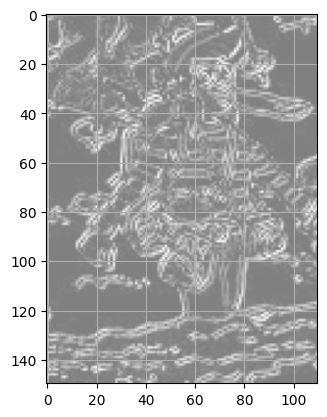

In [54]:
gray_waldo = rgb2gray(cropped_waldo2)
gray_8bit, edge_mask = hp_edge_detection(gray_waldo)
pic = png_generator(edge_mask)

#fingers crossed, please look okay
plt.imshow(gray_8bit, cmap='gray', vmin=-np.abs(HPRI).max(), vmax=np.abs(HPRI).max())
plt.axis("on")
plt.grid(True)
plt.show()

I wanted to see how the correlation function would work for kicks and giggles

In [ ]:
correlate_waldo = ()

y, x = np.unravel_index(np.argmax(corr), corr.shape) 
x_s = []
y_s = []
for i, value in enumerate(corr.flatten()):
    if value == corr.max():
        y, x = np.unravel_index(i, corr.shape)
        y_s.append(y)
        x_s.append(x)

plt.imshow(I, cmap='gray')
plt.plot(x_s, y_s, 'go')